# Report
This report aims to develop an VQ-VAE AutoEncoder for AudioMNIST. The development process involved several key steps:

Transforms Modification: Significant changes were made to the data transformation pipeline to correct syntax errors, object-oriented bugs, and logical inconsistencies, particularly in the Fast Fourier Transform implementation. These changes were necessary to ensure the data preprocessing pipeline's accuracy and effectiveness.

QVEN Selection: An existing Quantized Variational Encoder Network (QVEN) was in the project. However, with my experiments with the transformers I opt to find another impelementation. 

Autoencoder Training: The VQ-VAE AutoEncoder was trained for 100 epochs, indicating that it thoroughly explored the data space and reached model convergence. Epoch 89 was chosen as the backbone for the subsequent classifier, which used the autoencoder's learned representations for transfer learning.

Classifier Training: After freezing the backbone, the classifier was trained independently for 100 epochs. This strategy focused on fine-tuning the classifier while keeping the encoder parameters constant. The maximum accuracy of 71% demonstrated the classifier's effectiveness, though there is still room for improvement. However, after 40 epochs of training I lowered the learning rate.

Dataset Handling: Unlike traditional dataset splitting into train, validation, and test sets, only the training and validation sets were used in accordance with the provided example.

All the code used can be found in this notebook. And in 

# Imports

In [1]:
import os
from glob import glob
from typing import List, Callable

import numpy as np
import librosa

import torch
import torchvision
import lightning as L
import torch.nn.functional as F
import torch.nn as nn
from torchinfo import summary

from IPython.display import display
from IPython.display import Audio

import seaborn as sns
import matplotlib.pyplot as pyplot

from vmdpy import VMD
import pandas  as pd
from scipy import signal as Signal
from scipy import io as scio

/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Transform

In [2]:
class FixLength(Callable):
    def __init__(self, length):
        super(FixLength, self).__init__()
        self.length = length
    def __call__(self, waveform):
        return librosa.util.fix_length(waveform, size=self.length)
    def __repr__(self):
        repr = f"{self.__class__.__name__  }(length={self.length},)"
        return repr

class Expand(Callable):
    # FFT -> power spectrum
    def __init__(self, axis):
        super(Expand, self).__init__()
        self.axis = axis

    def __call__(self, waveform):
        # perform Fourier transform
        reshape_waveform = np.expand_dims(waveform, axis=self.axis)
        return reshape_waveform
    
    def __repr__(self):
        repr = f"{self.__class__.__name__  }(axis={self.axis},)"
        return repr

class FFT(Callable):
    # FFT -> power spectrum
    def __init__(self, **fft_args):
        super(FFT, self).__init__()
        self.fft_args = fft_args

    def __call__(self, waveform):
        # perform Fourier transform
        fft = np.fft.fft(waveform, **self.fft_args)
        fft = np.fft.fftshift(fft)
        spectrum = np.real(fft)
        left_spectrum = spectrum[:len(spectrum)//2]
        return left_spectrum
    
    def __repr__(self):
        repr = f"{self.__class__.__name__  }(fft_args={self.fft_args},)"
        return repr

class VMD_Decompositions(Callable):
    def __init__(self, **vmd_args):
        super(VMD_Decompositions, self).__init__()
        self.vmd_args = vmd_args

    def __call__(self, waveform):
        #. Run actual VMD code  
        u, _, _ = VMD(waveform, **self.vmd_args)
        return u
    
    def __repr__(self):
        repr = f"{self.__class__.__name__  }(vmd_args={self.vmd_args},)"
        return repr

# Dataloader

In [3]:
def convert_np_to_torch(numpy_data):
    return torch.Tensor(np.array(numpy_data, dtype=(np.float64)))


class AudioMNIST(torch.utils.data.Dataset):
    def __init__(self, 
                 root,
                 target_sample_rate = 22050,
                 normalize=True,
                 duration = None,
                 transform = None):
        super(AudioMNIST, self).__init__()
        self.root = root
        self.target_sample_rate = target_sample_rate
        self.duration = duration
        self.transform = transform
        self.wav_files = glob(f'{root}/*/*.wav', recursive=True)
        self.min_max = {}

    def __getitem__(self, index):
        file_name = self.wav_files[index]
        label = int(os.path.basename(file_name)[0])
        waveform, _ = librosa.load(file_name, sr=self.target_sample_rate, duration=self.duration, dtype=np.float64)
        
        if self.transform is not None:
            waveform = self.transform(waveform)
        
        waveform=convert_np_to_torch(waveform).unsqueeze(0)

        return waveform, label
    
    def __len__(self):
        return len(self.wav_files)

In [4]:
SAMPLE_RATE = 22050
SAMPLE_RND = 22016
dataset = AudioMNIST(
    root='./AudioMNIST/data', 
    target_sample_rate=SAMPLE_RATE,
    transform=torchvision.transforms.Compose([
        FixLength(SAMPLE_RND),
        FFT(),
    ]),
    normalize=False
)

In [5]:
total_dataset_length = len(dataset)
validation_dataset_length = int(total_dataset_length * 0.1)
train_dataset_length = total_dataset_length - validation_dataset_length
validation_dataset, _ = torch.utils.data.random_split(dataset, [train_dataset_length, validation_dataset_length])
train_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size = 512,
        shuffle=True,
        num_workers=4
)

validation_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size = 512,
        shuffle=False,
        num_workers=4
)

print(f"dataset:{total_dataset_length}, train:{train_dataset_length}, val:{validation_dataset_length}")

dataset:30000, train:27000, val:3000


# AutoEncoder

In [6]:
# Source: https://colab.research.google.com/github/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb#scrollTo=RuyCkd2cexQI
# just changed Conv2d to Conv1d and redo the permutes
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity, encodings

class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity, encodings
    
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv1d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv1d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)

class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv1d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv1d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv1d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.adaptive_avg_pool1d(input=x, output_size=5504)
        x = F.gelu(x)
        
        x = self._conv_2(x)
        x = F.adaptive_avg_pool1d(input=x, output_size=2752)
        x = F.gelu(x)
        
        x = self._conv_3(x)
        x = F.adaptive_avg_pool1d(input=x, output_size=512)
        x = F.gelu(x)
        return self._residual_stack(x)

class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv1d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose1d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose1d(in_channels=num_hiddens//2, 
                                                out_channels=1,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.adaptive_avg_pool1d(input=x, output_size=512)
        x = F.gelu(x)
        
        x = self._residual_stack(x)
        x = F.adaptive_avg_pool1d(input=x, output_size=2752)
        x = F.gelu(x)
        
        x = self._conv_trans_1(x)
        x = F.adaptive_avg_pool1d(input=x, output_size=5504)
        x = F.gelu(x)
        
        return self._conv_trans_2(x)
    
class AutoEncoder(L.LightningModule):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(AutoEncoder, self).__init__()
        
        self._encoder = Encoder(1, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv1d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=2, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)
        self.train_res_recon_error=[]
        self.train_res_perplexity=[]
        self.val_res_recon_error=[]
        self.val_res_perplexity=[]
        self.data_variance = 0.22708389
        self.counter=-1
        self.eval_step=5
        self.hist={'train':[], 'val':[]}

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        # print(z.shape)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity
    
    def training_step(self, batch, batch_idx):
        if batch_idx==0: self.counter += 1
        img, label = batch
        vq_loss, recon, perplexity = self.forward(img)
        # print(img.shape, recon.shape)
        recon_error = F.mse_loss(recon, img) / self.data_variance
        loss = recon_error + vq_loss
        self.log('train_loss', loss, prog_bar=True)

        self.train_res_recon_error.append(recon_error.item())
        self.train_res_perplexity.append(perplexity.item())

        if batch_idx==0 and self.counter%self.eval_step==0:
            self.hist['train'].append((loss, img[:3], recon[:3], label[:3]))
        
        if batch_idx==0 and self.counter>0:
            print(f'Train {self.counter-1}')
            print('recon_error: %.3f' % np.mean(self.train_res_recon_error))
            print('perplexity: %.3f' % np.mean(self.train_res_recon_error))
            self.train_res_recon_error=[]
            self.train_res_perplexity=[]
            print()
            

        return loss
    
    def validation_step(self, batch, batch_idx):
        # if self.counter%self.eval_step!=0: return None
        img, label = batch
        vq_loss, recon, perplexity = self.forward(img)
        # print(img.shape, recon.shape)
        recon_error = F.mse_loss(recon, img) / self.data_variance
        loss = recon_error + vq_loss
        self.log('val_loss', loss, prog_bar=True)

        self.val_res_recon_error.append(recon_error.item())
        self.val_res_perplexity.append(perplexity.item())

        if batch_idx==0 and self.counter%self.eval_step==0:
            self.hist['val'].append((loss, img[:3], recon[:3], label[:3]))
        
        if batch_idx==0 and self.counter>0:
            print(f'Val {self.counter-1}')
            print('recon_error: %.3f' % np.mean(self.val_res_recon_error))
            print('perplexity: %.3f' % np.mean(self.val_res_perplexity))
            self.val_res_recon_error=[]
            self.val_res_perplexity=[]
            print()

        return {'val_loss': loss}
        
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=4e-4, 
                               weight_decay=1e-6, amsgrad=False)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=27000//512, gamma=0.5, last_epoch=-1)
        return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}
    
    @staticmethod
    def plot_encoder_decoder(outputs: List, title: str):
        imgs = outputs[1].detach().cpu().numpy()
        recon = outputs[2].detach().cpu().numpy()
        labels = outputs[3].detach().cpu().numpy()
        print(title)
        for i, item in enumerate(imgs):
                print(f'label: {labels[i]}')
                display(Audio(data=item.squeeze(), rate=SAMPLE_RATE))
                display(librosa.display.waveshow(item.squeeze(), sr=SAMPLE_RATE, color="blue"))
                print("Reconstruction: ")
                display(Audio(data=recon[i].squeeze(), rate=SAMPLE_RATE))
                display(librosa.display.waveshow(recon[i].squeeze(), sr=SAMPLE_RATE, color="red"))
        
     
    def plot_autoencoder_results(self, num_epochs):
        
        for k in range(0, num_epochs//self.eval_step):
            AutoEncoder.plot_encoder_decoder(self.hist["train"][k*self.eval_step], title=f"train_{k*self.eval_step}")
            AutoEncoder.plot_encoder_decoder(self.hist["val"][k*self.eval_step], title=f"val_{k*self.eval_step}")


In [7]:
torch.cuda.is_available()

True

In [9]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 1e-6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 4e-4

autoencoder = AutoEncoder(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

summary(autoencoder, input_size=(1, 1, 11008), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                        Output Shape              Param #
AutoEncoder                                   --                        --
+ Encoder: 1-1                                [1, 128, 512]             --
|    + Conv1d: 2-1                            [1, 64, 5504]             320
|    + Conv1d: 2-2                            [1, 128, 2752]            32,896
|    + Conv1d: 2-3                            [1, 128, 2752]            49,280
|    + ResidualStack: 2-4                     [1, 128, 512]             --
|    |    + ModuleList: 3-1                   --                        32,768
+ Conv1d: 1-2                                 [1, 64, 511]              16,448
+ VectorQuantizerEMA: 1-3                     --                        65,536
+ Decoder: 1-4                                [1, 1, 11008]             --
|    + Conv1d: 2-5                            [1, 128, 511]             24,704
|    + ResidualStack: 2-6                     [1, 128, 512]           

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type               | Params
----------------------------------------------------
0 | _encoder     | Encoder            | 115 K 
1 | _pre_vq_

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Train 0
recon_error: 1.127
perplexity: 1.127



Validation: |          | 0/? [00:00<?, ?it/s]

Val 0
recon_error: 1.030
perplexity: 1.130

Train 1
recon_error: 0.966
perplexity: 0.966



Validation: |          | 0/? [00:00<?, ?it/s]

Val 1
recon_error: 0.946
perplexity: 1.470

Train 2
recon_error: 0.909
perplexity: 0.909



Validation: |          | 0/? [00:00<?, ?it/s]

Val 2
recon_error: 0.887
perplexity: 1.980

Train 3
recon_error: 0.872
perplexity: 0.872



Validation: |          | 0/? [00:00<?, ?it/s]

Val 3
recon_error: 0.865
perplexity: 2.555

Train 4
recon_error: 0.852
perplexity: 0.852



Validation: |          | 0/? [00:00<?, ?it/s]

Val 4
recon_error: 0.844
perplexity: 3.114

Train 5
recon_error: 0.833
perplexity: 0.833



Validation: |          | 0/? [00:00<?, ?it/s]

Val 5
recon_error: 0.829
perplexity: 2.760

Train 6
recon_error: 0.827
perplexity: 0.827



Validation: |          | 0/? [00:00<?, ?it/s]

Val 6
recon_error: 0.817
perplexity: 3.087

Train 7
recon_error: 0.808
perplexity: 0.808



Validation: |          | 0/? [00:00<?, ?it/s]

Val 7
recon_error: 0.807
perplexity: 3.529

Train 8
recon_error: 0.804
perplexity: 0.804



Validation: |          | 0/? [00:00<?, ?it/s]

Val 8
recon_error: 0.809
perplexity: 3.208

Train 9
recon_error: 0.802
perplexity: 0.802



Validation: |          | 0/? [00:00<?, ?it/s]

Val 9
recon_error: 0.797
perplexity: 3.242

Train 10
recon_error: 0.787
perplexity: 0.787



Validation: |          | 0/? [00:00<?, ?it/s]

Val 10
recon_error: 0.792
perplexity: 4.165

Train 11
recon_error: 0.783
perplexity: 0.783



Validation: |          | 0/? [00:00<?, ?it/s]

Val 11
recon_error: 0.788
perplexity: 4.362

Train 12
recon_error: 0.783
perplexity: 0.783



Validation: |          | 0/? [00:00<?, ?it/s]

Val 12
recon_error: 0.779
perplexity: 5.354

Train 13
recon_error: 0.773
perplexity: 0.773



Validation: |          | 0/? [00:00<?, ?it/s]

Val 13
recon_error: 0.780
perplexity: 6.496

Train 14
recon_error: 0.767
perplexity: 0.767



Validation: |          | 0/? [00:00<?, ?it/s]

Val 14
recon_error: 0.778
perplexity: 6.544

Train 15
recon_error: 0.762
perplexity: 0.762



Validation: |          | 0/? [00:00<?, ?it/s]

Val 15
recon_error: 0.763
perplexity: 7.008

Train 16
recon_error: 0.757
perplexity: 0.757



Validation: |          | 0/? [00:00<?, ?it/s]

Val 16
recon_error: 0.755
perplexity: 8.104

Train 17
recon_error: 0.746
perplexity: 0.746



Validation: |          | 0/? [00:00<?, ?it/s]

Val 17
recon_error: 0.751
perplexity: 8.489

Train 18
recon_error: 0.742
perplexity: 0.742



Validation: |          | 0/? [00:00<?, ?it/s]

Val 18
recon_error: 0.745
perplexity: 8.970

Train 19
recon_error: 0.739
perplexity: 0.739



Validation: |          | 0/? [00:00<?, ?it/s]

Val 19
recon_error: 0.738
perplexity: 8.476

Train 20
recon_error: 0.728
perplexity: 0.728



Validation: |          | 0/? [00:00<?, ?it/s]

Val 20
recon_error: 0.732
perplexity: 8.579

Train 21
recon_error: 0.727
perplexity: 0.727



Validation: |          | 0/? [00:00<?, ?it/s]

Val 21
recon_error: 0.724
perplexity: 10.881

Train 22
recon_error: 0.725
perplexity: 0.725



Validation: |          | 0/? [00:00<?, ?it/s]

Val 22
recon_error: 0.723
perplexity: 11.255

Train 23
recon_error: 0.724
perplexity: 0.724



Validation: |          | 0/? [00:00<?, ?it/s]

Val 23
recon_error: 0.723
perplexity: 9.827

Train 24
recon_error: 0.711
perplexity: 0.711



Validation: |          | 0/? [00:00<?, ?it/s]

Val 24
recon_error: 0.717
perplexity: 9.974

Train 25
recon_error: 0.711
perplexity: 0.711



Validation: |          | 0/? [00:00<?, ?it/s]

Val 25
recon_error: 0.714
perplexity: 11.122

Train 26
recon_error: 0.707
perplexity: 0.707



Validation: |          | 0/? [00:00<?, ?it/s]

Val 26
recon_error: 0.711
perplexity: 10.850

Train 27
recon_error: 0.709
perplexity: 0.709



Validation: |          | 0/? [00:00<?, ?it/s]

Val 27
recon_error: 0.705
perplexity: 9.008

Train 28
recon_error: 0.705
perplexity: 0.705



Validation: |          | 0/? [00:00<?, ?it/s]

Val 28
recon_error: 0.704
perplexity: 8.097

Train 29
recon_error: 0.706
perplexity: 0.706



Validation: |          | 0/? [00:00<?, ?it/s]

Val 29
recon_error: 0.703
perplexity: 10.474

Train 30
recon_error: 0.701
perplexity: 0.701



Validation: |          | 0/? [00:00<?, ?it/s]

Val 30
recon_error: 0.700
perplexity: 12.326

Train 31
recon_error: 0.692
perplexity: 0.692



Validation: |          | 0/? [00:00<?, ?it/s]

Val 31
recon_error: 0.705
perplexity: 10.918

Train 32
recon_error: 0.688
perplexity: 0.688



Validation: |          | 0/? [00:00<?, ?it/s]

Val 32
recon_error: 0.701
perplexity: 12.310

Train 33
recon_error: 0.691
perplexity: 0.691



Validation: |          | 0/? [00:00<?, ?it/s]

Val 33
recon_error: 0.698
perplexity: 9.808

Train 34
recon_error: 0.688
perplexity: 0.688



Validation: |          | 0/? [00:00<?, ?it/s]

Val 34
recon_error: 0.695
perplexity: 10.503

Train 35
recon_error: 0.690
perplexity: 0.690



Validation: |          | 0/? [00:00<?, ?it/s]

Val 35
recon_error: 0.686
perplexity: 9.713

Train 36
recon_error: 0.685
perplexity: 0.685



Validation: |          | 0/? [00:00<?, ?it/s]

Val 36
recon_error: 0.694
perplexity: 9.861

Train 37
recon_error: 0.679
perplexity: 0.679



Validation: |          | 0/? [00:00<?, ?it/s]

Val 37
recon_error: 0.694
perplexity: 10.492

Train 38
recon_error: 0.678
perplexity: 0.678



Validation: |          | 0/? [00:00<?, ?it/s]

Val 38
recon_error: 0.681
perplexity: 10.095

Train 39
recon_error: 0.684
perplexity: 0.684



Validation: |          | 0/? [00:00<?, ?it/s]

Val 39
recon_error: 0.679
perplexity: 9.496

Train 40
recon_error: 0.672
perplexity: 0.672



Validation: |          | 0/? [00:00<?, ?it/s]

Val 40
recon_error: 0.683
perplexity: 10.479

Train 41
recon_error: 0.675
perplexity: 0.675



Validation: |          | 0/? [00:00<?, ?it/s]

Val 41
recon_error: 0.683
perplexity: 10.906

Train 42
recon_error: 0.672
perplexity: 0.672



Validation: |          | 0/? [00:00<?, ?it/s]

Val 42
recon_error: 0.679
perplexity: 11.005

Train 43
recon_error: 0.669
perplexity: 0.669



Validation: |          | 0/? [00:00<?, ?it/s]

Val 43
recon_error: 0.669
perplexity: 10.626

Train 44
recon_error: 0.671
perplexity: 0.671



Validation: |          | 0/? [00:00<?, ?it/s]

Val 44
recon_error: 0.673
perplexity: 11.272

Train 45
recon_error: 0.665
perplexity: 0.665



Validation: |          | 0/? [00:00<?, ?it/s]

Val 45
recon_error: 0.673
perplexity: 8.627

Train 46
recon_error: 0.663
perplexity: 0.663



Validation: |          | 0/? [00:00<?, ?it/s]

Val 46
recon_error: 0.666
perplexity: 10.224

Train 47
recon_error: 0.669
perplexity: 0.669



Validation: |          | 0/? [00:00<?, ?it/s]

Val 47
recon_error: 0.663
perplexity: 10.669

Train 48
recon_error: 0.657
perplexity: 0.657



Validation: |          | 0/? [00:00<?, ?it/s]

Val 48
recon_error: 0.664
perplexity: 8.629

Train 49
recon_error: 0.667
perplexity: 0.667



Validation: |          | 0/? [00:00<?, ?it/s]

Val 49
recon_error: 0.671
perplexity: 9.893

Train 50
recon_error: 0.655
perplexity: 0.655



Validation: |          | 0/? [00:00<?, ?it/s]

Val 50
recon_error: 0.659
perplexity: 11.200

Train 51
recon_error: 0.660
perplexity: 0.660



Validation: |          | 0/? [00:00<?, ?it/s]

Val 51
recon_error: 0.662
perplexity: 9.829

Train 52
recon_error: 0.648
perplexity: 0.648



Validation: |          | 0/? [00:00<?, ?it/s]

Val 52
recon_error: 0.655
perplexity: 11.366

Train 53
recon_error: 0.655
perplexity: 0.655



Validation: |          | 0/? [00:00<?, ?it/s]

Val 53
recon_error: 0.654
perplexity: 12.091

Train 54
recon_error: 0.646
perplexity: 0.646



Validation: |          | 0/? [00:00<?, ?it/s]

Val 54
recon_error: 0.657
perplexity: 10.522

Train 55
recon_error: 0.656
perplexity: 0.656



Validation: |          | 0/? [00:00<?, ?it/s]

Val 55
recon_error: 0.650
perplexity: 10.869

Train 56
recon_error: 0.647
perplexity: 0.647



Validation: |          | 0/? [00:00<?, ?it/s]

Val 56
recon_error: 0.653
perplexity: 10.866

Train 57
recon_error: 0.645
perplexity: 0.645



Validation: |          | 0/? [00:00<?, ?it/s]

Val 57
recon_error: 0.648
perplexity: 10.553

Train 58
recon_error: 0.642
perplexity: 0.642



Validation: |          | 0/? [00:00<?, ?it/s]

Val 58
recon_error: 0.658
perplexity: 10.458

Train 59
recon_error: 0.649
perplexity: 0.649



Validation: |          | 0/? [00:00<?, ?it/s]

Val 59
recon_error: 0.650
perplexity: 10.127

Train 60
recon_error: 0.648
perplexity: 0.648



Validation: |          | 0/? [00:00<?, ?it/s]

Val 60
recon_error: 0.644
perplexity: 9.845

Train 61
recon_error: 0.653
perplexity: 0.653



Validation: |          | 0/? [00:00<?, ?it/s]

Val 61
recon_error: 0.649
perplexity: 10.455

Train 62
recon_error: 0.640
perplexity: 0.640



Validation: |          | 0/? [00:00<?, ?it/s]

Val 62
recon_error: 0.645
perplexity: 11.668

Train 63
recon_error: 0.643
perplexity: 0.643



Validation: |          | 0/? [00:00<?, ?it/s]

Val 63
recon_error: 0.646
perplexity: 9.672

Train 64
recon_error: 0.643
perplexity: 0.643



Validation: |          | 0/? [00:00<?, ?it/s]

Val 64
recon_error: 0.648
perplexity: 11.492

Train 65
recon_error: 0.645
perplexity: 0.645



Validation: |          | 0/? [00:00<?, ?it/s]

Val 65
recon_error: 0.646
perplexity: 10.110

Train 66
recon_error: 0.642
perplexity: 0.642



Validation: |          | 0/? [00:00<?, ?it/s]

Val 66
recon_error: 0.647
perplexity: 10.140

Train 67
recon_error: 0.643
perplexity: 0.643



Validation: |          | 0/? [00:00<?, ?it/s]

Val 67
recon_error: 0.659
perplexity: 9.827

Train 68
recon_error: 0.637
perplexity: 0.637



Validation: |          | 0/? [00:00<?, ?it/s]

Val 68
recon_error: 0.646
perplexity: 9.979

Train 69
recon_error: 0.639
perplexity: 0.639



Validation: |          | 0/? [00:00<?, ?it/s]

Val 69
recon_error: 0.641
perplexity: 8.946

Train 70
recon_error: 0.637
perplexity: 0.637



Validation: |          | 0/? [00:00<?, ?it/s]

Val 70
recon_error: 0.646
perplexity: 10.224

Train 71
recon_error: 0.639
perplexity: 0.639



Validation: |          | 0/? [00:00<?, ?it/s]

Val 71
recon_error: 0.645
perplexity: 8.311

Train 72
recon_error: 0.641
perplexity: 0.641



Validation: |          | 0/? [00:00<?, ?it/s]

Val 72
recon_error: 0.641
perplexity: 8.657

Train 73
recon_error: 0.637
perplexity: 0.637



Validation: |          | 0/? [00:00<?, ?it/s]

Val 73
recon_error: 0.642
perplexity: 8.715

Train 74
recon_error: 0.641
perplexity: 0.641



Validation: |          | 0/? [00:00<?, ?it/s]

Val 74
recon_error: 0.642
perplexity: 9.205

Train 75
recon_error: 0.636
perplexity: 0.636



Validation: |          | 0/? [00:00<?, ?it/s]

Val 75
recon_error: 0.641
perplexity: 8.454

Train 76
recon_error: 0.640
perplexity: 0.640



Validation: |          | 0/? [00:00<?, ?it/s]

Val 76
recon_error: 0.635
perplexity: 8.289

Train 77
recon_error: 0.642
perplexity: 0.642



Validation: |          | 0/? [00:00<?, ?it/s]

Val 77
recon_error: 0.640
perplexity: 9.088

Train 78
recon_error: 0.633
perplexity: 0.633



Validation: |          | 0/? [00:00<?, ?it/s]

Val 78
recon_error: 0.648
perplexity: 8.086

Train 79
recon_error: 0.635
perplexity: 0.635



Validation: |          | 0/? [00:00<?, ?it/s]

Val 79
recon_error: 0.646
perplexity: 7.573

Train 80
recon_error: 0.636
perplexity: 0.636



Validation: |          | 0/? [00:00<?, ?it/s]

Val 80
recon_error: 0.634
perplexity: 8.199

Train 81
recon_error: 0.639
perplexity: 0.639



Validation: |          | 0/? [00:00<?, ?it/s]

Val 81
recon_error: 0.638
perplexity: 8.210

Train 82
recon_error: 0.635
perplexity: 0.635



Validation: |          | 0/? [00:00<?, ?it/s]

Val 82
recon_error: 0.637
perplexity: 7.888

Train 83
recon_error: 0.633
perplexity: 0.633



Validation: |          | 0/? [00:00<?, ?it/s]

Val 83
recon_error: 0.633
perplexity: 7.704

Train 84
recon_error: 0.631
perplexity: 0.631



Validation: |          | 0/? [00:00<?, ?it/s]

Val 84
recon_error: 0.635
perplexity: 7.307

Train 85
recon_error: 0.633
perplexity: 0.633



Validation: |          | 0/? [00:00<?, ?it/s]

Val 85
recon_error: 0.641
perplexity: 7.443

Train 86
recon_error: 0.635
perplexity: 0.635



Validation: |          | 0/? [00:00<?, ?it/s]

Val 86
recon_error: 0.636
perplexity: 7.251

Train 87
recon_error: 0.626
perplexity: 0.626



Validation: |          | 0/? [00:00<?, ?it/s]

Val 87
recon_error: 0.642
perplexity: 6.605

Train 88
recon_error: 0.636
perplexity: 0.636



Validation: |          | 0/? [00:00<?, ?it/s]

Val 88
recon_error: 0.635
perplexity: 6.409

Train 89
recon_error: 0.630
perplexity: 0.630



Validation: |          | 0/? [00:00<?, ?it/s]

Val 89
recon_error: 0.638
perplexity: 6.938

Train 90
recon_error: 0.634
perplexity: 0.634



Validation: |          | 0/? [00:00<?, ?it/s]

Val 90
recon_error: 0.635
perplexity: 6.806

Train 91
recon_error: 0.636
perplexity: 0.636



Validation: |          | 0/? [00:00<?, ?it/s]

Val 91
recon_error: 0.641
perplexity: 6.446

Train 92
recon_error: 0.632
perplexity: 0.632



Validation: |          | 0/? [00:00<?, ?it/s]

Val 92
recon_error: 0.637
perplexity: 6.456

Train 93
recon_error: 0.631
perplexity: 0.631



Validation: |          | 0/? [00:00<?, ?it/s]

Val 93
recon_error: 0.637
perplexity: 6.398

Train 94
recon_error: 0.629
perplexity: 0.629



Validation: |          | 0/? [00:00<?, ?it/s]

Val 94
recon_error: 0.633
perplexity: 6.392

Train 95
recon_error: 0.633
perplexity: 0.633



Validation: |          | 0/? [00:00<?, ?it/s]

Val 95
recon_error: 0.632
perplexity: 6.169

Train 96
recon_error: 0.633
perplexity: 0.633



Validation: |          | 0/? [00:00<?, ?it/s]

Val 96
recon_error: 0.638
perplexity: 6.516

Train 97
recon_error: 0.627
perplexity: 0.627



Validation: |          | 0/? [00:00<?, ?it/s]

Val 97
recon_error: 0.634
perplexity: 6.027

Train 98
recon_error: 0.634
perplexity: 0.634



Validation: |          | 0/? [00:00<?, ?it/s]

Val 98
recon_error: 0.632
perplexity: 6.036



`Trainer.fit` stopped: `max_epochs=100` reached.


train_0
label: 7


Reconstruction: 


label: 1


Reconstruction: 


label: 2


Reconstruction: 


val_0
label: 4


Reconstruction: 


label: 1


Reconstruction: 


label: 5


Reconstruction: 


train_5
label: 0


Reconstruction: 


label: 1


Reconstruction: 


label: 3


Reconstruction: 


val_5
label: 4


Reconstruction: 


label: 1


Reconstruction: 


label: 5


Reconstruction: 


train_10
label: 8


Reconstruction: 


label: 9


Reconstruction: 


label: 7


Reconstruction: 


val_10
label: 4


Reconstruction: 


label: 1


Reconstruction: 


label: 5


Reconstruction: 


train_15
label: 3


Reconstruction: 


label: 4


Reconstruction: 


label: 1


Reconstruction: 


val_15
label: 4


Reconstruction: 


label: 1


Reconstruction: 


label: 5


Reconstruction: 


IndexError: list index out of range

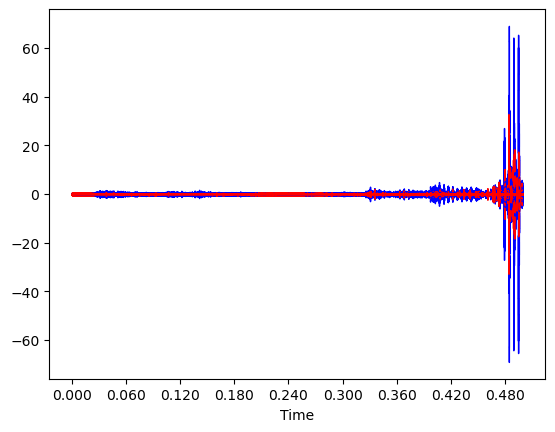

In [9]:
torch.cuda.empty_cache()

# train model
trainer = L.Trainer(max_epochs=100)
# I've changed the model for ray tuneing so now it will get DataModule instead of dataloader
trainer.fit(autoencoder, train_loader, validation_loader)
autoencoder.plot_autoencoder_results(100)

# Classifier

In [12]:
from collections import OrderedDict
from torchmetrics import Accuracy

class AudioMNISTClassifier(L.LightningModule):
    def __init__(self, num_classes, learning_rate=2e-4):
        super().__init__()
        
        backbone = AutoEncoder(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay)

        checkpoint = torch.load('./lightning_logs/version_2/epoch=89-step=5310.ckpt')
        # create new OrderedDict that does not contain `module.`
        new_state_dict = OrderedDict()
        for k, v in checkpoint['state_dict'].items():
            new_state_dict[k] = v

        backbone.load_state_dict(new_state_dict)

        self.features = nn.Sequential(backbone._encoder, backbone._pre_vq_conv, nn.GELU(),)
        self.classifier = nn.Sequential(nn.Conv1d(in_channels=64, 
                                      out_channels=1,
                                      kernel_size=2, 
                                      stride=4),  nn.GELU(), nn.Linear(128, num_classes))

        self.learning_rate=learning_rate
        self.criterion = nn.CrossEntropyLoss()

        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)


    # returns the feature tensor from the conv block
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze()
        # print(y.shape, logits.shape)
        loss = self.criterion(logits, y)
        
        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.train_accuracy(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze()
        loss = self.criterion(logits, y)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.val_accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.classifier.parameters(), lr=self.learning_rate)
        return optimizer


In [10]:
classifier = AudioMNISTClassifier(num_classes=59, learning_rate=2e-4)
summary(classifier, input_size=(1, 1, 11008), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                             Output Shape              Param #
AudioMNISTClassifier                               [1, 1, 59]                --
+ Sequential: 1-1                                  [1, 64, 511]              --
|    + Encoder: 2-1                                [1, 128, 512]             --
|    |    + Conv1d: 3-1                            [1, 64, 5504]             320
|    |    + Conv1d: 3-2                            [1, 128, 2752]            32,896
|    |    + Conv1d: 3-3                            [1, 128, 2752]            49,280
|    |    + ResidualStack: 3-4                     [1, 128, 512]             32,768
|    + Conv1d: 2-2                                 [1, 64, 511]              16,448
|    + GELU: 2-3                                   [1, 64, 511]              --
+ Sequential: 1-2                                  [1, 1, 59]                --
|    + Conv1d: 2-4                                 [1, 1, 128]               129
|    + GELU: 2-5 

In [13]:
torch.cuda.empty_cache()
classifier = AudioMNISTClassifier(num_classes=59, learning_rate=2e-4).to(device)
# train model
trainer = L.Trainer(max_epochs=20)
# I've changed the model for ray tuneing so now it will get DataModule instead of dataloader
trainer.fit(classifier, train_loader, validation_loader)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type               | Params
------------------------------------------------------
0 | features       | Sequential         | 131 K 
1 | classifier     | Sequential         | 7.7 K 
2 | criterion      | CrossEntropyLoss   | 0     
3 | train_accuracy | MulticlassAccuracy | 0     
4 | val_accuracy   | MulticlassAccuracy | 0     
------------------------------------------------------
139 K     Trainable params
0         Non-trainable params
139 K     Total params
0.558     Total estimated model params

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [16]:
classifier.learning_rate = 4e-4
trainer = L.Trainer(max_epochs=20)
trainer.fit(classifier, train_loader, validation_loader)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type               | Params
------------------------------------------------------
0 | features       | Sequential         | 131 K 
1 | classifier     | Sequential         | 7.7 K 
2 | criterion      | CrossEntropyLoss   | 0     
3 | train_accuracy | MulticlassAccuracy | 0     
4 | val_accuracy   | MulticlassAccuracy | 0     
------------------------------------------------------
139 K     Trainable params
0         Non-trainable params
139 K     Total params
0.558     Total estimated model params

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [17]:
trainer = L.Trainer(max_epochs=20)
trainer.fit(classifier, train_loader, validation_loader)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type               | Params
------------------------------------------------------
0 | features       | Sequential         | 131 K 
1 | classifier     | Sequential         | 7.7 K 
2 | criterion      | CrossEntropyLoss   | 0     
3 | train_accuracy | MulticlassAccuracy | 0     
4 | val_accuracy   | MulticlassAccuracy | 0     
------------------------------------------------------
139 K     Trainable params
0         Non-trainable params
139 K     Total params
0.558     Total estimated model params

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [18]:
trainer = L.Trainer(max_epochs=20)
trainer.fit(classifier, train_loader, validation_loader)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type               | Params
------------------------------------------------------
0 | features       | Sequential         | 131 K 
1 | classifier     | Sequential         | 7.7 K 
2 | criterion      | CrossEntropyLoss   | 0     
3 | train_accuracy | MulticlassAccuracy | 0     
4 | val_accuracy   | MulticlassAccuracy | 0     
------------------------------------------------------
139 K     Trainable params
0         Non-trainable params
139 K     Total params
0.558     Total estimated model params

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


# Junk

In [91]:
tst_data, label = next(iter(validation_loader))

In [92]:
print("Input shape:", tst_data.shape)
print(tst_data.max(), tst_data.min())
### Do normalization in the forward, as is now, or add it to the transforms

Input shape: torch.Size([512, 1, 11008])
tensor(63.1646) tensor(-69.1030)


In [104]:
batch = next(iter(validation_loader))
classifier = AudioMNISTClassifier(num_classes=59, learning_rate=2e-4)
classifier.training_step(batch, 0)

torch.Size([512]) torch.Size([512, 59])


/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/lightning/pytorch/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(4.2378, grad_fn=<NllLossBackward0>)

In [ ]:
# inverse = FFT()(tst_data.squeeze())
inverse = (tst_data.squeeze())
inverse=np.concatenate((inverse, np.conjugate(inverse)), axis=0)
inverse = np.real(np.fft.ifft(np.fft.ifftshift(inverse)))
inverse= inverse[:int(len(inverse)/2)]
x= np.fft.fftshift(np.fft.fftfreq(tst_data.shape[-1]))

In [ ]:
print(inverse.shape[0]/SAMPLE_RATE)

0.4992290249433107


label: tensor([8])


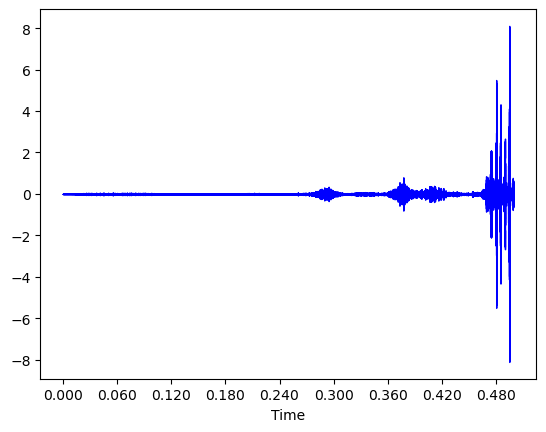

In [ ]:
librosa.display.waveshow(tst_data.squeeze().numpy(), sr=SAMPLE_RATE, color="blue")   #show the inverse

print(f"label: {label}")
Audio(data=tst_data.squeeze(), rate=SAMPLE_RATE) # play the inverse

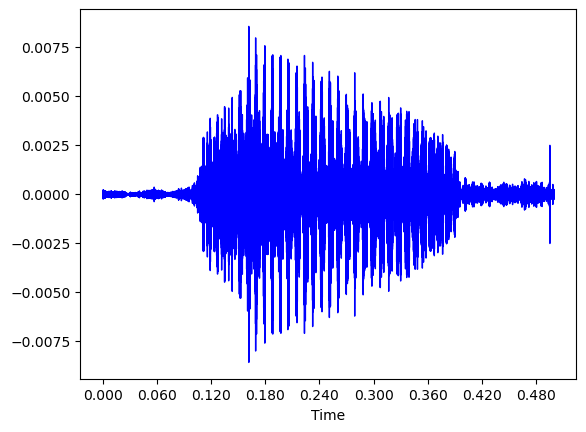

In [ ]:
librosa.display.waveshow(inverse, sr=SAMPLE_RATE, color="blue")   #show the inverse
Audio(data=inverse, rate=SAMPLE_RATE)

AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'

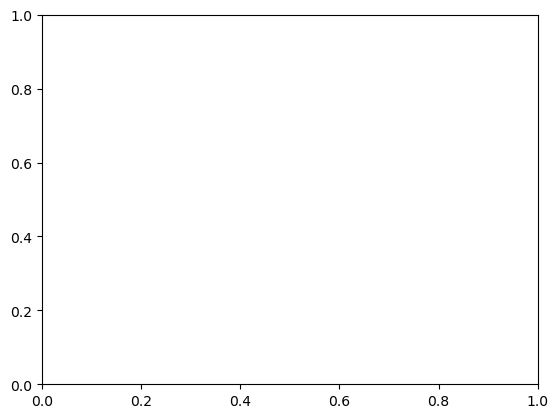

<IPython.lib.display.Audio object>
<IPython.lib.display.Audio object>


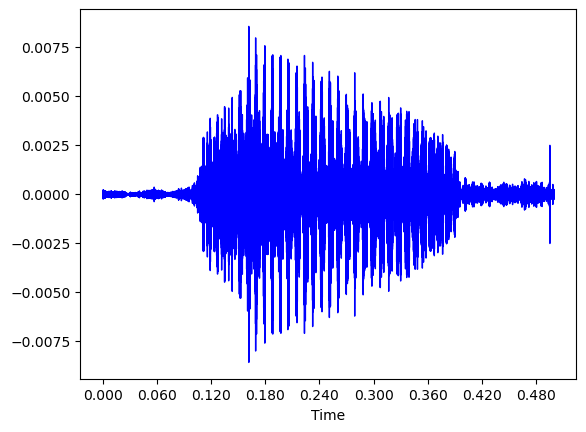

In [140]:
librosa.display.waveshow(inverse, sr=SAMPLE_RATE, color="blue")   #show the inverse
print(Audio(data=inverse, rate=SAMPLE_RATE))
print(Audio(data=inverse, rate=SAMPLE_RATE))

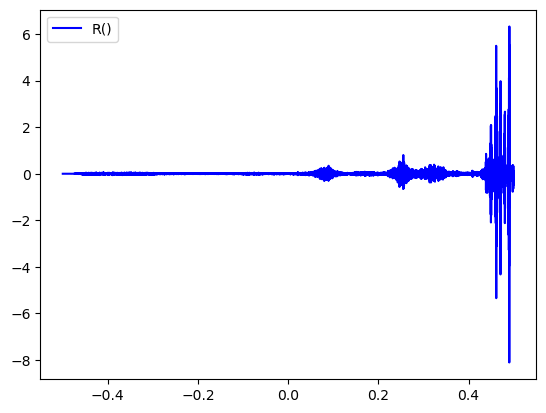

In [ ]:
f = pyplot.figure()
ax = f.add_subplot(111)
ax.plot(x, tst_data.squeeze().numpy(), 'b', label='R()')
ax.legend()

In [ ]:
def aggregated_modes(imfs: np.array):
    return np.sum(imfs, axis=1)

def plot_series_decomposition(series: np.array, imfs:np.array, K: int= 5,) -> None:

    fig, axes = pyplot.subplots(K+2)
    sns.lineplot(data=series.real, ax = axes[0], legend=False)

    for i in range(K):
        sns.lineplot(data=imfs[i], ax = axes[i+1])


    sns.lineplot(data=(series.real[:imfs.shape[0]] - aggregated_modes(imfs)), ax = axes[K+1], legend=False)

    pyplot.suptitle("VMD Decomposition")

    for ax in axes[:-1]:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set(ylabel=None)

    axes[0].set_title('modes')
    axes[0].set(ylabel='.wave')
    axes[K+1].set(ylabel='Reminder')

    pyplot.subplots_adjust()
    pyplot.show()

/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

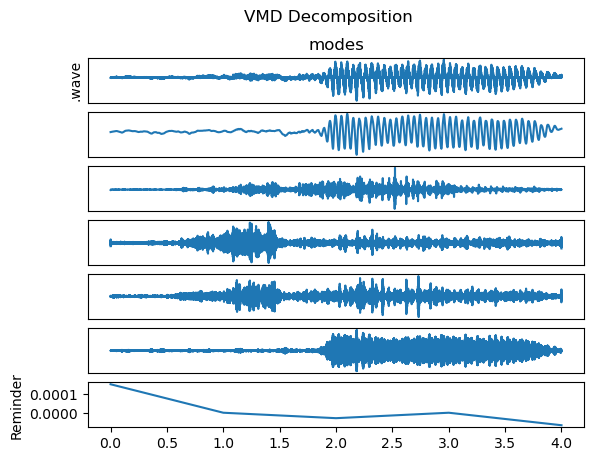

In [ ]:
alpha = 5000      # moderate bandwidth constraint  
tau =  0.          # noise-tolerance (no strict fidelity enforcement)  
K = 5             # 3 modes  
DC = 1             # no DC part imposed  
init = 1           # initialize omegas uniformly  
tol = 5e-6

imfs = decompose_series(series=inverse, alpha=alpha, tau=tau, K=K, DC=DC, init=init, tol= tol)
plot_series_decomposition(series=inverse, imfs=imfs, K=K,)

In [11]:
a = []
for tst_data, label in train_loader:
    a.append(tst_data.squeeze().numpy())

c = np.concatenate(a, axis=0)
np.var(c)

0.22708389

In [13]:
0.22708389 / 255.0

0.0008905250588235295